### Equipo 2

Imanol Muñiz Ramirez A01701713

Julieta Itzel Pichardo Meza

Paul Park

Rodrigo Antonio Benítez De La Portilla A01771433

Carlos Iván Fonseca Mondragón A01771689

### Importar librerías y ver si el gpu existe y está listo para usarse.

Para que se pueda utilizar el gpu es importante descargar la versión de torch adecuada. Por default torch usa el cpu

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
print(torch.__version__)
print(torch.cuda.is_available())
if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
else:
	print("CUDA device not available")


2.6.0+cu124
True
Tesla P100-PCIE-16GB


### Función para normalizar los valores de los pixeles de las imágenes

In [2]:
def normalize_ct(img, min_hu=-1000, max_hu=400):
    img = np.clip(img, min_hu, max_hu)          # recorta valores extremos
    img = (img - min_hu) / (max_hu - min_hu)   # escala a [0,1]
    return img

Toma la imagen en valores de tomografía (HU) y primero ignora extremos que no aportan, aplastándolos dentro de un rango útil.
Ese rango elegido va de -1000 (aire muy oscuro) a 400 (tejidos más densos relevantes).
Si un píxel está por debajo de -1000 se fija en -1000 y si está por encima de 400 se baja a 400.
Así se reduce ruido y se mantiene el contraste clínicamente interesante del pulmón.
Luego mueve todo el rango para que empiece en cero restando -1000 a cada valor.
Después divide por el ancho total del rango (1400) para que el máximo quede en uno.
El resultado es una imagen con valores entre 0 y 1 fácil de usar por la red neuronal.

### Ver imágenes con sus máscaras

En el código de abajo importamos los datasets de entrenamiento. images_medseg.npy contiene 100 matrices de 512 por 512 pixeles que conforman las imágenes CT. Por otra parte masks_medseg.npy contiene 100 matrices, cada una con cuatro canales que marca los segmentos de cada una de las imágenes CT. Según el concurso de Kaggle la segmentación fue echa por un radiologo usando la herramento MedSeg.

Asignamos el color rojo para "ground glass", verde para "consolidaciones", azul para "lungs other" y negro/transparente para "backgroud"

Etse bloque carga las imágenes y máscaras desde archivos .npy, asegura que tengan un canal extra si venían en 3D (añadiendo la dimensión final), toma un corte (el índice 50), extrae su máscara correspondiente y construye una imagen RGB vacía donde pinta en rojo, verde y azul los píxeles de cada una de las clases activas en la máscara (dejando el fondo negro). Luego muestra dos figuras: a la izquierda la tomografía original en escala de grises y a la derecha la misma imagen con la máscara coloreada superpuesta con transparencia para visualizar fácilmente las zonas marcadas.

Forma real de images: (100, 512, 512, 1)
Nueva forma de images: (100, 512, 512, 1)
Forma real de masks: (100, 512, 512, 4)
Nueva forma de masks: (100, 512, 512, 4)


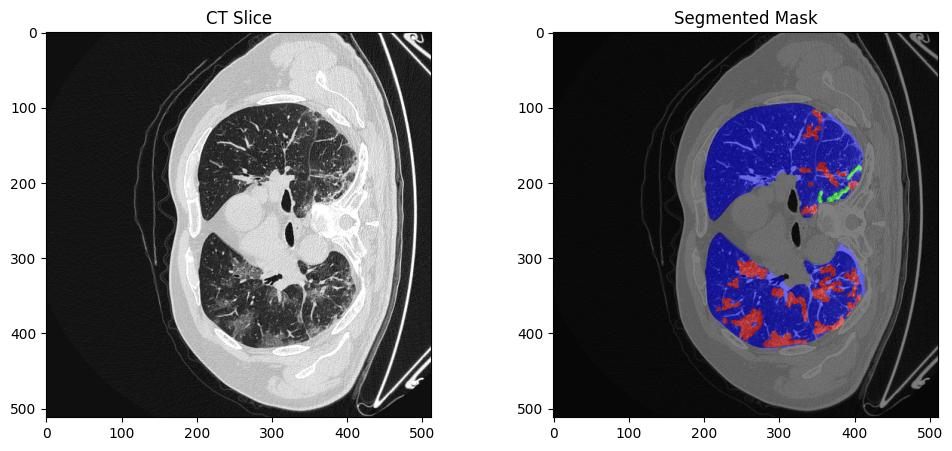

In [3]:
# Cargar arrays
images = np.load("/kaggle/input/covid-segmentation/images_medseg.npy")
print("Forma real de images:", images.shape)
if images.ndim == 3:
    images = np.expand_dims(images, axis=-1)
print("Nueva forma de images:", images.shape)

masks = np.load("/kaggle/input/covid-segmentation/masks_medseg.npy")
print("Forma real de masks:", masks.shape)
if masks.ndim == 3:
    masks = np.expand_dims(masks, axis=-1)
print("Nueva forma de masks:", masks.shape)

# Elegimos un slice
i = 50
slice_img = images[i]        # (512, 512)
slice_mask = masks[i]        # (512, 512, 4) o (512, 512, 1)

# Crear una máscara combinada con colores
# Inicializamos un canvas RGB vacío
colored_mask = np.zeros((512, 512, 3), dtype=np.float32)

# Asignamos colores a cada clase
if slice_mask.shape[-1] >= 3:
    colored_mask[slice_mask[...,0] == 1] = [1, 0, 0]  # Rojo = ground glass
    colored_mask[slice_mask[...,1] == 1] = [0, 1, 0]  # Verde = consolidaciones
    colored_mask[slice_mask[...,2] == 1] = [0, 0, 1]  # Azul = lungs other
# (el canal 3 = background, lo dejamos negro/transparente)

plt.figure(figsize=(12,5))

# Imagen original
plt.subplot(1,2,1)
plt.imshow(slice_img.squeeze(), cmap="gray")
plt.title("CT Slice")

# Imagen + máscara
plt.subplot(1,2,2)
plt.imshow(slice_img.squeeze(), cmap="gray")
plt.imshow(colored_mask, alpha=0.5)  # superposición
plt.title("Segmented Mask")

plt.show()


In [4]:
print("images shape:", images.shape)
print("masks shape:", masks.shape)

images shape: (100, 512, 512, 1)
masks shape: (100, 512, 512, 4)


### Entrenamiento

Para el entrenamiento del modelo elegimos el más convencional para segmentar imágenes de rayos X "UNet". Como función de perdida utilziamos "cross entropy loss" y adicionalmente usamos el algoritmo de optimización de parámetros de la red neuronal "Adam". 

UNet es una arquitectura de red neuronal convolucional diseñada para segmentación semántica de imágenes (cada píxel recibe una clase).

Para entrenar el modelo creamos 3 clases. CovidSegDataset nos ayuda a manejar las imágenes y máscaras para dejarlas en formatos listos para el entrenamiento. 

Las clases DoubleConv y UNet son las que llevan acabo el entrenamiento a través de la red neuronal convolucional. 

Reúne todo el “motor” de entrenamiento: define la clase que prepara cada par imagen‑máscara normalizando la imagen y pasando la máscara de formato one‑hot a números de clase, construye la arquitectura U‑Net (baja resolución para extraer características y luego la recupera mezclando detalles), carga los archivos de imágenes y máscaras desde disco y los convierte en un dataset, separa automáticamente los ejemplos en entrenamiento y validación para poder vigilar el rendimiento, crea los cargadores por lotes que alimentan la red, calcula pesos por clase (a partir de cuántos píxeles hay de cada tipo) para que la pérdida dé más importancia a las clases menos frecuentes, arma la función de pérdida y el optimizador, detecta si hay GPU disponible y finalmente ejecuta un bucle de 125 épocas donde en cada una entrena sobre los lotes, acumula la pérdida promedio y luego evalúa en validación informando ambas pérdidas por época para seguir la evolución del aprendizaje.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

# Dataset personalizado
class CovidSegDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]              # (512,512,1)
        mask = self.masks[idx]              # (512,512,4)

        # Normalizar la imagen CT
        img = np.squeeze(img, axis=-1)      # (512,512)
        img = normalize_ct(img)             # [0,1]
        img = np.expand_dims(img, axis=0)   # (1,512,512)

        # Convertir máscara a multiclase (0-3)
        mask = np.argmax(mask, axis=-1)     # (512,512)

        img = torch.tensor(img, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.long)

        return img, mask


# U-Net extendido
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # Encoder
        self.down1 = DoubleConv(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.out_conv = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        d3 = self.down3(p2)
        p3 = self.pool3(d3)
        d4 = self.down4(p3)
        p4 = self.pool4(d4)

        b = self.bottleneck(p4)

        # Decoder
        u4 = self.up4(b)
        c4 = self.conv4(torch.cat([u4, d4], dim=1))
        u3 = self.up3(c4)
        c3 = self.conv3(torch.cat([u3, d3], dim=1))
        u2 = self.up2(c3)
        c2 = self.conv2(torch.cat([u2, d2], dim=1))
        u1 = self.up1(c2)
        c1 = self.conv1(torch.cat([u1, d1], dim=1))

        out = self.out_conv(c1)
        return out

# Preparar data
images = np.load("/kaggle/input/covid-segmentation/images_medseg.npy")
masks = np.load("/kaggle/input/covid-segmentation/masks_medseg.npy")
print("images shape:", images.shape)
print("masks shape:", masks.shape)
dataset = CovidSegDataset(images, masks)

# Split en train y validation (80% train, 20% val)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

model = UNet(n_classes=4).to(device)
# Asegúrate de que masks está en CPU
# Convierte masks (NumPy) a tensor
masks_tensor = torch.tensor(masks, dtype=torch.float32)  # (N,512,512,4)

# Convierte one-hot a clases (0-3)
mask_classes = torch.argmax(masks_tensor, dim=-1)         # (N,512,512)

# Cuenta pixeles por clase
pix_per_class = torch.tensor([torch.sum(mask_classes == i).item() for i in range(4)], dtype=torch.float32)

# Crear pesos inversos
weights = 1.0 / (pix_per_class + 1e-6)
weights = weights / weights.sum()  # normalizar

# Mover a dispositivo del modelo
weights = weights.to(device)

# Definir loss con pesos
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Entrenamiento básico con validación y registro de pérdidas
train_losses = []
val_losses = []
for epoch in range(130):
    model.train()
    running_loss = 0.0
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(loader)
    train_losses.append(avg_train_loss)

    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


images shape: (100, 512, 512, 1)
masks shape: (100, 512, 512, 4)
Usando dispositivo: cuda
Epoch 0, Train Loss: 1.3708, Val Loss: 1.3359
Epoch 1, Train Loss: 1.1893, Val Loss: 1.1309
Epoch 2, Train Loss: 1.1062, Val Loss: 1.0101
Epoch 3, Train Loss: 1.0538, Val Loss: 0.9724
Epoch 4, Train Loss: 0.9658, Val Loss: 0.9498
Epoch 5, Train Loss: 0.8844, Val Loss: 0.7784
Epoch 6, Train Loss: 0.7706, Val Loss: 0.7150
Epoch 7, Train Loss: 0.8618, Val Loss: 0.8221
Epoch 8, Train Loss: 0.7440, Val Loss: 0.6999
Epoch 9, Train Loss: 0.7118, Val Loss: 0.7442
Epoch 10, Train Loss: 0.7597, Val Loss: 0.7227
Epoch 11, Train Loss: 0.7633, Val Loss: 0.6826
Epoch 12, Train Loss: 0.7102, Val Loss: 0.6726
Epoch 13, Train Loss: 0.6635, Val Loss: 0.6345
Epoch 14, Train Loss: 0.6624, Val Loss: 0.6884
Epoch 15, Train Loss: 0.6784, Val Loss: 0.6531
Epoch 16, Train Loss: 0.6475, Val Loss: 0.6740
Epoch 17, Train Loss: 0.6704, Val Loss: 0.6217
Epoch 18, Train Loss: 0.6489, Val Loss: 0.6293
Epoch 19, Train Loss: 0.705

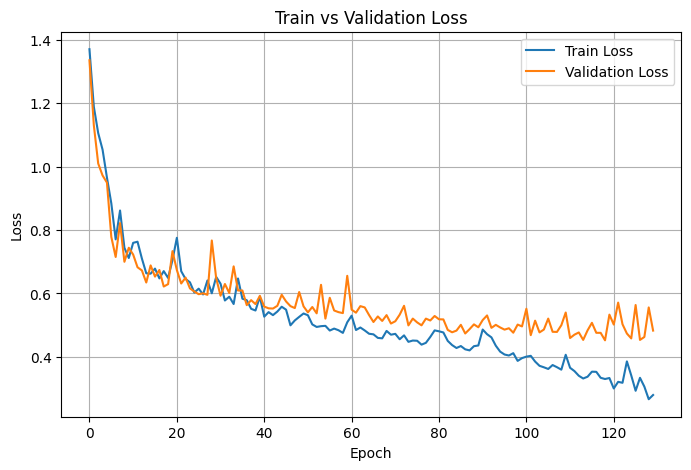

In [6]:
# Graficar pérdidas de entrenamiento y validación
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


### Segmentar dataset de test en 4 segmentos

En el código de abajo tomamos las 10 imágenes de test y las segmentamos de acuerdo con lo que aprendió nuestro modelo. 

Esta celda crea el dataset de prueba que toma cada imagen de test, le quita el canal sobrante, la normaliza y la convierte a tensor; luego carga todas las imágenes desde el archivo, arma un DataLoader para recorrerlas de una en una, pone el modelo en modo evaluación y elige si usar CPU o GPU. Después, para cada slice pasa la imagen por la red, obtiene la clase más probable por píxel, construye una máscara coloreada (rojo, verde, azul según la clase) y muestra dos vistas: a la izquierda la tomografía en gris y a la derecha la misma imagen con la predicción superpuesta con transparencia para visualizar claramente las zonas detectadas por el modelo.

test shape: (10, 512, 512, 1)


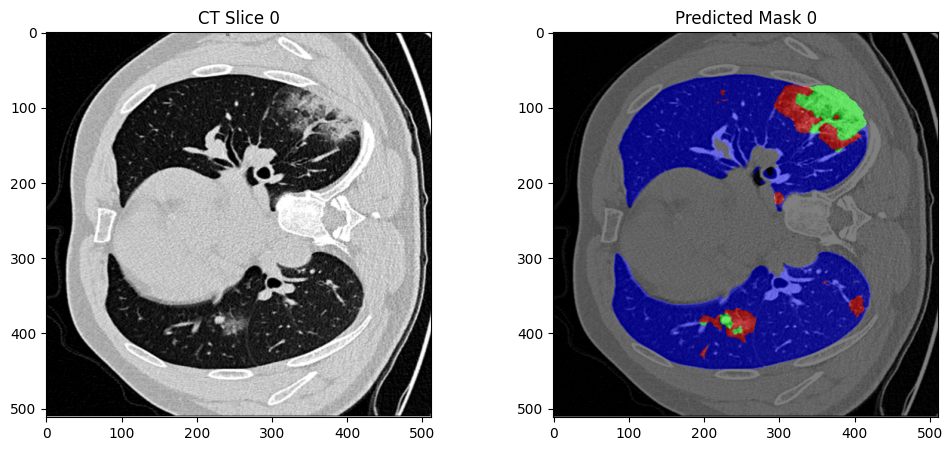

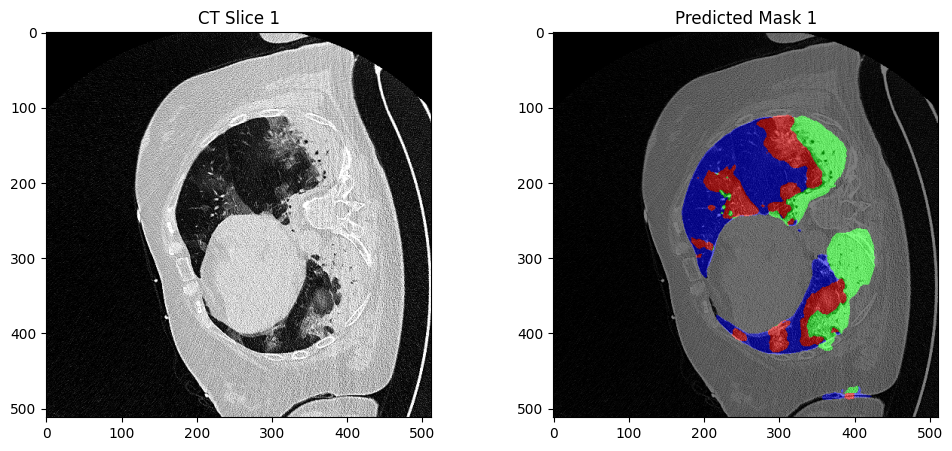

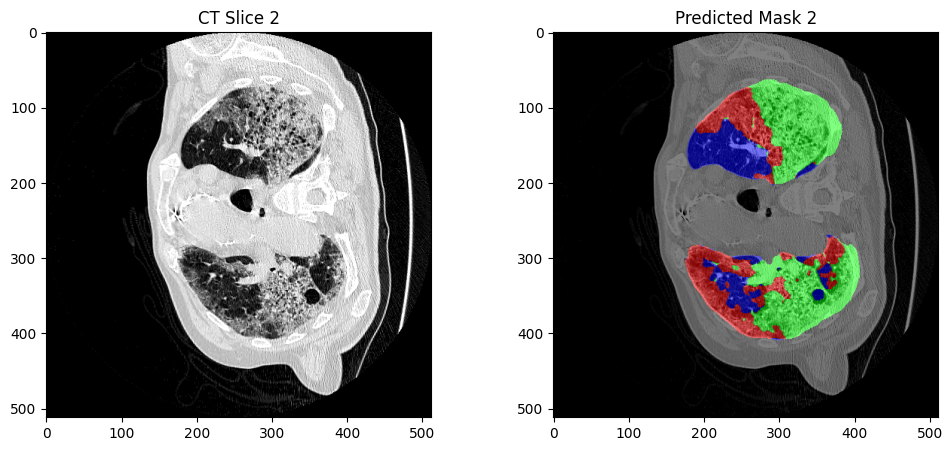

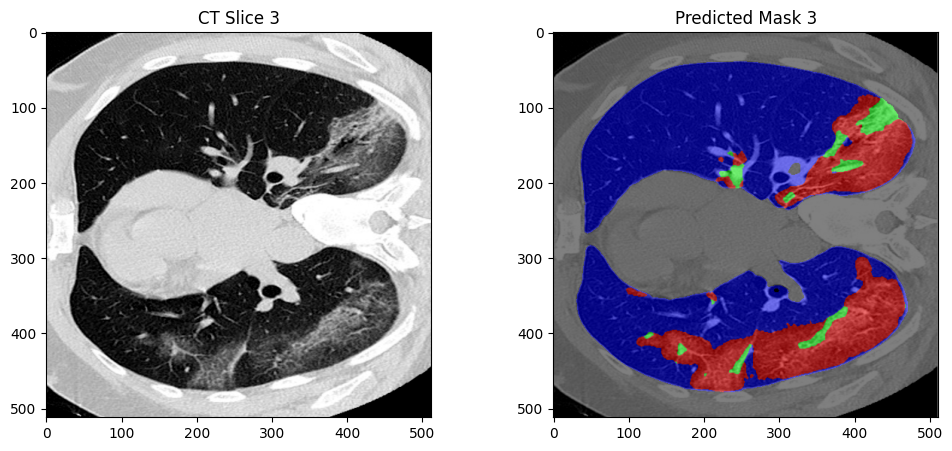

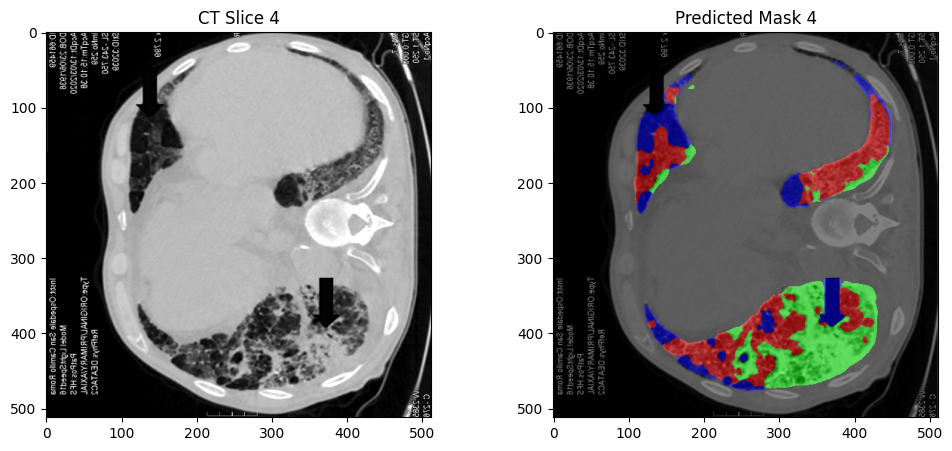

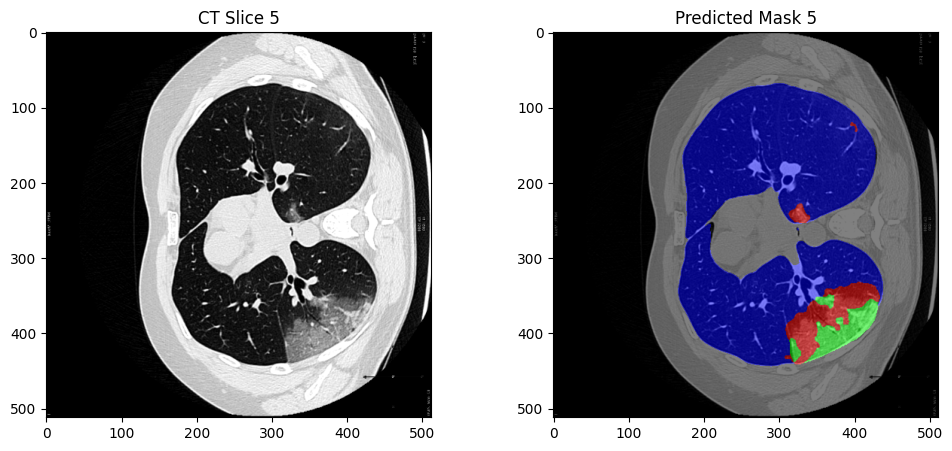

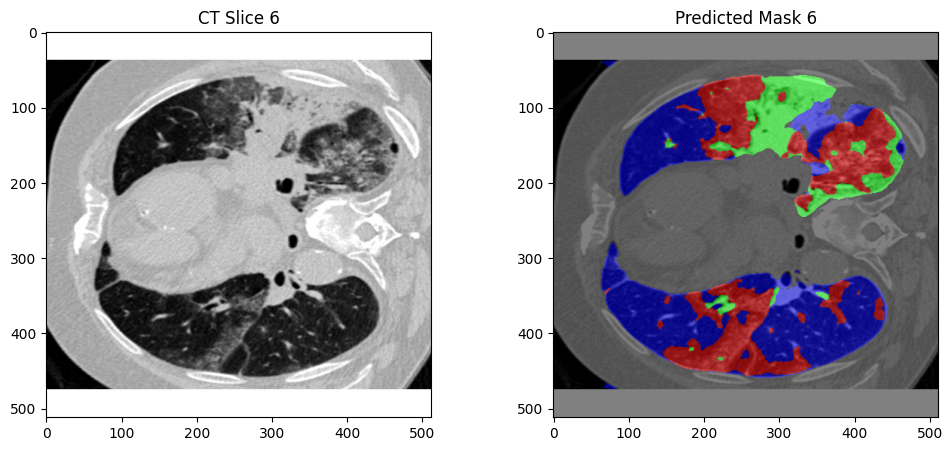

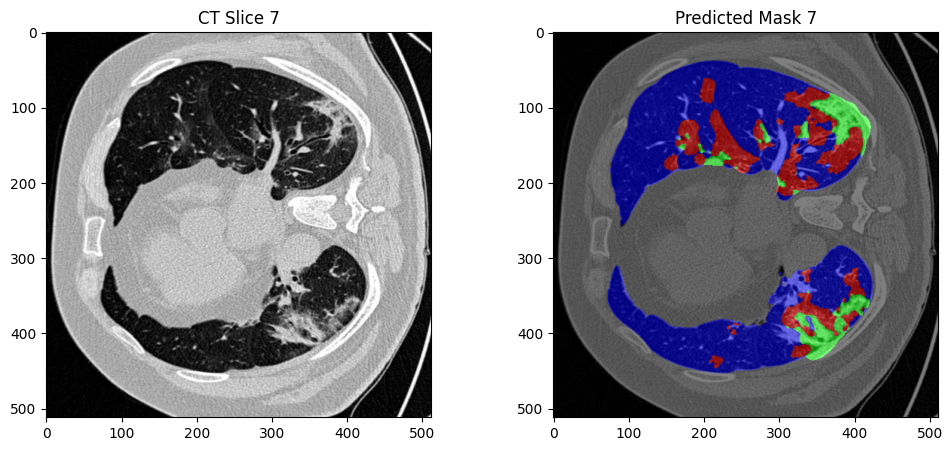

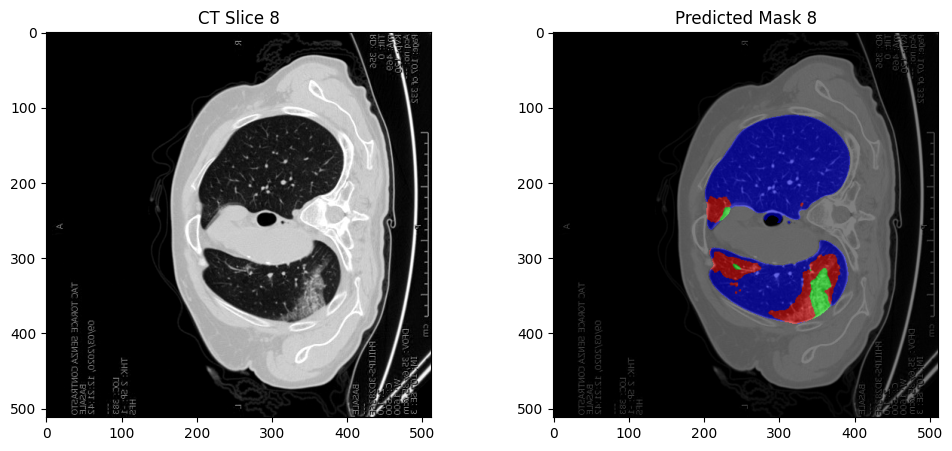

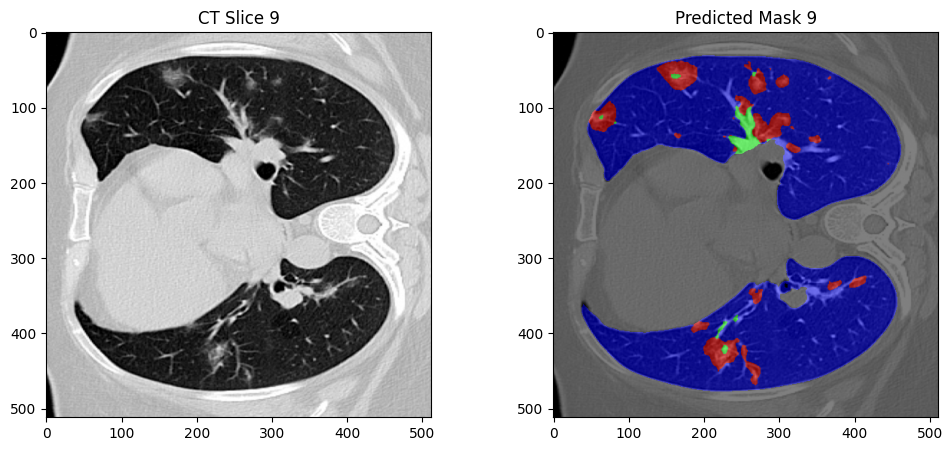

In [7]:
class CovidTestDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]          # (512,512,1)
        img = np.squeeze(img, axis=-1)  # (512,512)
        img = normalize_ct(img)         # escala a [0,1]
        img = np.expand_dims(img, axis=0)
        img = torch.tensor(img, dtype=torch.float32)
        return img


test = np.load("/kaggle/input/covid-segmentation/test_images_medseg.npy")
print("test shape:", test.shape)
test_dataset = CovidTestDataset(test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Asegúrate de que el modelo está en modo evaluación
model.eval()

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loop por cada slice de prueba
for i, batch in enumerate(test_loader):
    batch = batch.to(device)
    with torch.no_grad():
        preds = model(batch)                # (B,4,512,512)
        pred_masks = torch.argmax(preds, dim=1)  # (B,512,512)

    for j in range(batch.size(0)):
        img_np = batch[j].squeeze(0).cpu().numpy()
        pred_mask_np = pred_masks[j].cpu().numpy()

        colored_mask = np.zeros((512,512,3), dtype=np.float32)
        colored_mask[pred_mask_np == 0] = [1,0,0]
        colored_mask[pred_mask_np == 1] = [0,1,0]
        colored_mask[pred_mask_np == 2] = [0,0,1]

        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.imshow(img_np, cmap="gray")
        plt.title(f"CT Slice {i*batch.size(0)+j}")

        plt.subplot(1,2,2)
        plt.imshow(img_np, cmap="gray")
        plt.imshow(colored_mask, alpha=0.5)
        plt.title(f"Predicted Mask {i*batch.size(0)+j}")
        plt.show()


### Generar solo segmentos de ground glass y consolidaciones para el dataset de test

Finalmente hacemos lo mismo que en el código anterior, pero solo segmentamos para ground glass y consolidaciones. Generamos un arreglo y posteriomente los ponemos en el formato que pide el concurso de Kaggle

Esta parte toma el modelo ya entrenado y genera, para cada slice de test, un arreglo binario con solo dos canales: uno para píxeles que el modelo clasifica como “ground glass”  y otro para “consolidations” . Primero vuelve a crear el DataLoader sobre el dataset de test y pone el modelo en modo evaluación. Reserva mask_array con forma (n_slices, 512, 512, 2) lleno de ceros. Dentro del bloque torch.no_grad() recorre cada imagen: pasa la entrada por el modelo, obtiene los logits de salida (4 canales), aplica argmax para convertirlos en un mapa de clases por píxel y lo lleva a NumPy. Luego llena el canal 0 del mask_array con 1 donde la predicción es clase 0 y el canal 1 donde es clase 1; los demás píxeles quedan en 0. Al final imprime la forma final del arreglo para confirmar que coincide con el número de slices y la estructura esperada.



In [8]:
test_dataset = CovidTestDataset(test)  # usa tu dataset normalizado
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inicializar array final
num_slices = len(test_dataset)
mask_array = np.zeros((num_slices, 512, 512, 2), dtype=np.uint8)

test = np.load("/kaggle/input/covid-segmentation/test_images_medseg.npy")

with torch.no_grad():
    for i, img in enumerate(test_loader):
        img = img.to(device)
        pred = model(img)                     # (B,4,512,512)
        pred_mask = torch.argmax(pred, dim=1) # (B,512,512)

        pred_mask_np = pred_mask.squeeze(0).cpu().numpy()  # (512,512)

        # Crear canales binarios
        mask_array[i, :, :, 0] = (pred_mask_np == 0).astype(np.uint8)  # ground glass
        mask_array[i, :, :, 1] = (pred_mask_np == 1).astype(np.uint8)  # consolidations

print("Final mask array shape:", mask_array.shape)


Final mask array shape: (10, 512, 512, 2)


Generar el formato de entrega de kaggle

In [9]:
import pandas as pd
pd.DataFrame(
             data=np.stack((np.arange(len(mask_array.ravel())), 
                                        mask_array.ravel().astype(int)),
                                       axis=-1), 
             columns=['Id', 'Predicted'])\
.set_index('Id').to_csv('submission1.csv')
